In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyberbullying-dataset/twitter_sexism_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/youtube_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/kaggle_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/aggression_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/toxicity_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/attack_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/twitter_racism_parsed_dataset.csv


In [40]:
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [41]:
df3 = pd.read_csv('/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv')
df3

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0
...,...,...,...,...,...
16846,5.75606766236475E+017,5.75606766236475E+017,"Feeling so sorry for the girls, they should be...",none,0.0
16847,5.72333822886326E+017,5.72333822886326E+017,#MKR 'pretty good dishes we're happy with' - O...,none,0.0
16848,5.72326950057845E+017,5.72326950057845E+017,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,5.74799612642357E+017,5.74799612642357E+017,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0


In [42]:
df3.dropna(inplace=True)

In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Sample DataFrame


# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Category' column
df3['Encoded_Category'] = label_encoder.fit_transform(df3['Annotation'])
encoding_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Encoded values and their corresponding categories:")
print(encoding_map)
# df3

Encoded values and their corresponding categories:
{'none': 0, 'racism': 1, 'sexism': 2}


In [44]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

# Sample text data and labels
texts = df3['Text']  # List of texts
labels = df3['Encoded_Category']
texts

0        @halalflaws @biebervalue @greenlinerzjm I read...
1        @ShreyaBafna3 Now you idiots claim that people...
2        RT @Mooseoftorment Call me sexist, but when I ...
3        @g0ssipsquirrelx Wrong, ISIS follows the examp...
4                                   #mkr No No No No No No
                               ...                        
16846    Feeling so sorry for the girls, they should be...
16847    #MKR 'pretty good dishes we're happy with' - O...
16848    RT @colonelkickhead: Deconstructed lemon tart!...
16849    @versacezaynx @nyazpolitics @greenlinerzjm You...
16850    And before you protest that you're *not* mad, ...
Name: Text, Length: 16848, dtype: object

In [45]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def token_counter(text, tokenizer):
    return len(tokenizer.encode(text))

tok_len = df3["Text"].apply(lambda x : token_counter(x, tokenizer))

max(list(tok_len))

84

In [46]:
tokenizer.model_max_length = 100

In [47]:
def tokenize(text, tokenizer):
    return tokenizer.encode(text, padding='max_length')

In [48]:
from sklearn.model_selection import train_test_split

X = list(df3['Text'].apply(lambda x : tokenize(x, tokenizer)))
y = list(df3['Encoded_Category'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=10)

In [49]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
        
        
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])
    
    def __len__(self):
        return len(self.labels)

train_dataset = CreateDataset(X_train, y_train)
test_dataset = CreateDataset(X_test, y_test)

In [50]:
train_dataset[0]

(tensor([    0,   100,  1266,     6,    52,   214,    23,  1009,   459,  1988,
          3226,   501,     4,   787, 27404, 18287,  9487,   787,   133, 12444,
          5246, 36734,  5073,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]),
 tensor(0))

In [51]:
len(train_dataset),len(test_dataset)

(13478, 3370)

In [52]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size = 32)

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [54]:
class LSTMModel(nn.Module):
    
    def __init__(self, vocab_size,output_size, embedding_dim, hidden_size, num_layers, dropout = 0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim, 
                            hidden_size = hidden_size, 
                            num_layers = num_layers,
                            dropout = dropout,
                            batch_first = True,
                            bidirectional = True)
        self.linear = nn.Linear(hidden_size*200, output_size)
        
    def forward(self, inputs):
        emb = self.embedding(inputs)
        
        h0 = torch.zeros(n_layers*2, inputs.size(0), hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(n_layers*2, inputs.size(0), hidden_dim).requires_grad_().to(device)
        
        lstm_out, h = self.lstm(emb, (h0, c0))
        
        output = self.linear(lstm_out.reshape(lstm_out.size()[0], -1))
        
        return output
    


In [58]:
vocab_size = tokenizer.vocab_size
embedding_dim = 100
hidden_dim = 32
n_layers = 2
output_size = 3

model = LSTMModel(vocab_size,output_size, embedding_dim, hidden_dim, n_layers).to(device)

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
num_epochs  = 25

loss_list = []
iteration_list_train = []
count_train = 0

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Compute the forward pass through the network up to the loss
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            loss_list.append(loss.data) 

            # Backward and optimize

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            count_train += 1
            iteration_list_train.append(count_train) 

            if (i+1) % 200 == 0:                    
                print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                     %(epoch+1, num_epochs, i+1, len(train_dataset)//32, loss.item()))

Epoch [1/25], Step [200/421], Loss: 0.6539
Epoch [1/25], Step [400/421], Loss: 0.3639
Epoch [2/25], Step [200/421], Loss: 0.5821
Epoch [2/25], Step [400/421], Loss: 0.1921
Epoch [3/25], Step [200/421], Loss: 0.4860
Epoch [3/25], Step [400/421], Loss: 0.0921
Epoch [4/25], Step [200/421], Loss: 0.2519
Epoch [4/25], Step [400/421], Loss: 0.0426
Epoch [5/25], Step [200/421], Loss: 0.1211
Epoch [5/25], Step [400/421], Loss: 0.0261
Epoch [6/25], Step [200/421], Loss: 0.0487
Epoch [6/25], Step [400/421], Loss: 0.0046
Epoch [7/25], Step [200/421], Loss: 0.0129
Epoch [7/25], Step [400/421], Loss: 0.0111
Epoch [8/25], Step [200/421], Loss: 0.0150
Epoch [8/25], Step [400/421], Loss: 0.0134
Epoch [9/25], Step [200/421], Loss: 0.0307
Epoch [9/25], Step [400/421], Loss: 0.0018
Epoch [10/25], Step [200/421], Loss: 0.0023
Epoch [10/25], Step [400/421], Loss: 0.0019
Epoch [11/25], Step [200/421], Loss: 0.0010
Epoch [11/25], Step [400/421], Loss: 0.0339
Epoch [12/25], Step [200/421], Loss: 0.0499
Epoch 

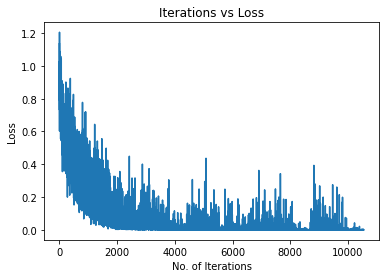

In [61]:
import matplotlib.pyplot as plt

plt.plot(iteration_list_train, loss_list)
plt.xlabel("No. of Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [62]:
accuracy_list = []
iteration_list_test = []
count_test = 0

y_pred = []
y_true = []

correct = 0
total = 0
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)

    total += targets.size(0)                    
    correct += (predicted == targets).sum()    

    count_test += 1
    iteration_list_test.append(count_test)  

    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    
    y_pred.extend(predicted.cpu())
    y_true.extend(targets.cpu())
    
print('Accuracy of the network on the test: %d %%' %accuracy)

Accuracy of the network on the test: 83 %
